<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_resnet_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResnetSolver

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

In [5]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [6]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         upper_limit_x,
                         lower_limit_s,
                         upper_limit_s,
                         lower_limit_p,
                         upper_limit_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device='cpu') 
    ) 
    x0_train[:,0] = x0_train[:,0] * upper_limit_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * upper_limit_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * upper_limit_p + lower_limit_p # product (0-40)
    return x0_train 

1. Create initial conditions for training 
    * 100 initial conditions are created 
    * biomass concentration goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentrations goes from 0 to 40 g/L

In [7]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 10, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 6.6090,  4.1964,  0.1340],
        [ 3.5234, 14.0915, 36.9128],
        [ 2.9183, 31.3286, 13.7410],
        [ 5.9197, 20.7349,  9.0490],
        [ 9.0963, 20.9632, 39.5635]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validation 
    * 100 initial conditions are created 
    * biomass concentration goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentrations goes from 0 to 40 g/L

In [8]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 3.6408,  9.3821, 25.5090],
        [ 9.4483, 24.9979,  5.1472],
        [ 7.7463,  5.9928,  3.4920],
        [ 4.8178, 18.5812,  9.4312],
        [ 8.5900, 12.6564, 14.4482]], dtype=torch.float64)
torch.Size([10, 3])


In [9]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

3. Create time span for training
    * Each time span is of 1 hour
4. Create time span for validation 
    * Each time span is of 60 hours

In [10]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories 
    * Each training trajectory contains two observations. The initial conditions and one step haead

In [11]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

In [12]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")


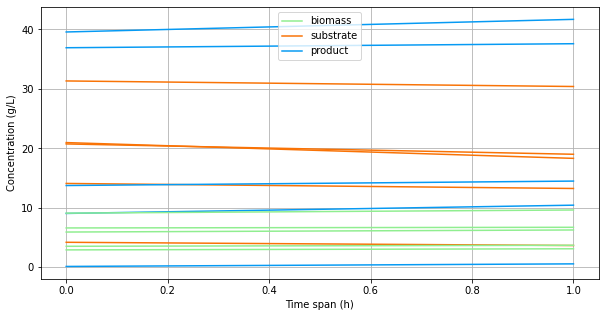

In [13]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validations trajectories 
    * Each validations trajectory contains sixty one observations. The initial conditions and sixty steps haead

In [14]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

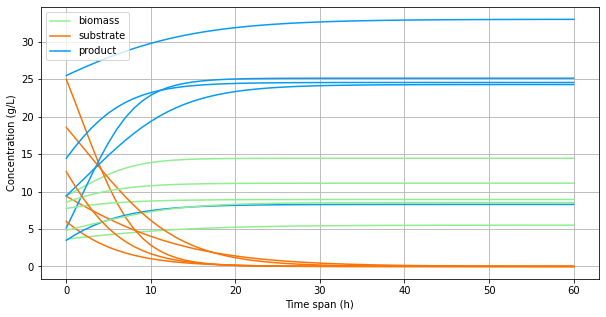

In [15]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Create the ANN model 
    * The input layer has three input neurons. It is a linear layer and there is no activations functions
    * There exist eight hidden layers each with thirty two neurons and a Sofplus activation function
    * The output layer has thirty two neurons and it is a simple linear function without activation functions 
    * The weights and biases are randomly initialized

In [16]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [37]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The training algorithm is Adam

In [38]:
# training algorithm
optimizer = Adam(net.parameters()) 

9. During training:
    * The loss functions is MSE
    * The training occurs for 2000 epochs 

In [39]:
import time 

In [40]:
start_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=ResnetSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver=ResnetSolver()
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")
end_time = time.time()

  0%|          | 5/2000 [00:00<00:42, 46.85it/s]

Epoch: 0 | Training loss: 1.4206721929224975 | Validate loss: 1346.183167054654


  3%|▎         | 59/2000 [00:01<00:40, 47.51it/s]

Epoch: 50 | Training loss: 0.12598053668290732 | Validate loss: 148.04319832913106


  5%|▌         | 109/2000 [00:02<00:37, 50.13it/s]

Epoch: 100 | Training loss: 0.0018079525302755074 | Validate loss: 19.159120425298223


  8%|▊         | 157/2000 [00:03<00:38, 48.23it/s]

Epoch: 150 | Training loss: 0.0004886983853586039 | Validate loss: 7.064478682049991


 10%|█         | 208/2000 [00:04<00:36, 48.72it/s]

Epoch: 200 | Training loss: 0.00031341370511369396 | Validate loss: 5.2104265621137005


 13%|█▎        | 256/2000 [00:05<00:36, 48.37it/s]

Epoch: 250 | Training loss: 0.00023841301599347858 | Validate loss: 4.0207560616117535


 16%|█▌        | 311/2000 [00:06<00:33, 50.61it/s]

Epoch: 300 | Training loss: 0.0001951944866376327 | Validate loss: 3.3766693097762155


 18%|█▊        | 359/2000 [00:07<00:32, 50.08it/s]

Epoch: 350 | Training loss: 0.0004104316812271617 | Validate loss: 3.693505945540517


 20%|██        | 407/2000 [00:08<00:31, 50.75it/s]

Epoch: 400 | Training loss: 0.00014771590183755372 | Validate loss: 2.5705040589381705


 23%|██▎       | 455/2000 [00:09<00:30, 50.29it/s]

Epoch: 450 | Training loss: 0.00016181778991363477 | Validate loss: 2.2465580154147764


 25%|██▌       | 509/2000 [00:10<00:29, 49.89it/s]

Epoch: 500 | Training loss: 0.00011934190190179818 | Validate loss: 2.1048770302403703


 28%|██▊       | 560/2000 [00:11<00:28, 49.74it/s]

Epoch: 550 | Training loss: 0.00010715797196511894 | Validate loss: 1.8277083500536615


 30%|███       | 605/2000 [00:12<00:27, 51.10it/s]

Epoch: 600 | Training loss: 9.912274514814386e-05 | Validate loss: 1.7248183575087528


 33%|███▎      | 659/2000 [00:13<00:27, 48.92it/s]

Epoch: 650 | Training loss: 9.016139305078253e-05 | Validate loss: 1.5444595766035352


 36%|███▌      | 711/2000 [00:14<00:25, 50.28it/s]

Epoch: 700 | Training loss: 0.0003633349351291296 | Validate loss: 1.7537110644663774


 38%|███▊      | 757/2000 [00:15<00:26, 46.54it/s]

Epoch: 750 | Training loss: 7.918248739239341e-05 | Validate loss: 1.2884280846741993


 41%|████      | 811/2000 [00:16<00:24, 49.43it/s]

Epoch: 800 | Training loss: 7.297637622289958e-05 | Validate loss: 1.2534325556445418


 43%|████▎     | 859/2000 [00:17<00:24, 46.66it/s]

Epoch: 850 | Training loss: 6.724211775882653e-05 | Validate loss: 1.1928240184146353


 45%|████▌     | 908/2000 [00:18<00:21, 49.69it/s]

Epoch: 900 | Training loss: 0.00011186940342457529 | Validate loss: 0.8284107791341784


 48%|████▊     | 961/2000 [00:19<00:20, 49.63it/s]

Epoch: 950 | Training loss: 5.999777116872609e-05 | Validate loss: 0.930840342952525


 50%|█████     | 1008/2000 [00:20<00:20, 49.26it/s]

Epoch: 1000 | Training loss: 5.5254740446554544e-05 | Validate loss: 0.9247041952118208


 53%|█████▎    | 1058/2000 [00:21<00:19, 47.27it/s]

Epoch: 1050 | Training loss: 5.12513691002026e-05 | Validate loss: 0.9478213402296237


 55%|█████▌    | 1108/2000 [00:22<00:18, 48.02it/s]

Epoch: 1100 | Training loss: 0.00011013337510211697 | Validate loss: 0.5012756222521395


 58%|█████▊    | 1156/2000 [00:23<00:17, 48.31it/s]

Epoch: 1150 | Training loss: 6.0312007612380034e-05 | Validate loss: 0.8554798482495763


 60%|██████    | 1209/2000 [00:24<00:16, 49.06it/s]

Epoch: 1200 | Training loss: 4.518041299913071e-05 | Validate loss: 0.898741830925464


 63%|██████▎   | 1257/2000 [00:25<00:15, 49.42it/s]

Epoch: 1250 | Training loss: 4.228633793757703e-05 | Validate loss: 0.9712844081284113


 65%|██████▌   | 1309/2000 [00:26<00:14, 47.70it/s]

Epoch: 1300 | Training loss: 3.976709298431433e-05 | Validate loss: 1.026575025086514


 68%|██████▊   | 1356/2000 [00:27<00:14, 44.71it/s]

Epoch: 1350 | Training loss: 3.7534006412227395e-05 | Validate loss: 1.083580497202433


 70%|███████   | 1406/2000 [00:28<00:11, 51.26it/s]

Epoch: 1400 | Training loss: 4.778154590866671e-05 | Validate loss: 0.3654541498577262


 73%|███████▎  | 1460/2000 [00:29<00:10, 50.50it/s]

Epoch: 1450 | Training loss: 3.778926924433406e-05 | Validate loss: 0.8535012024753282


 75%|███████▌  | 1506/2000 [00:30<00:09, 50.11it/s]

Epoch: 1500 | Training loss: 3.502994844479558e-05 | Validate loss: 0.9725214272600696


 78%|███████▊  | 1556/2000 [00:31<00:09, 48.63it/s]

Epoch: 1550 | Training loss: 3.3039291185412865e-05 | Validate loss: 1.0357589470112916


 80%|████████  | 1608/2000 [00:32<00:08, 46.41it/s]

Epoch: 1600 | Training loss: 3.128380034157362e-05 | Validate loss: 1.0761354881084415


 83%|████████▎ | 1657/2000 [00:33<00:06, 49.78it/s]

Epoch: 1650 | Training loss: 2.9689477973081345e-05 | Validate loss: 1.1048147787216067


 85%|████████▌ | 1707/2000 [00:34<00:05, 49.78it/s]

Epoch: 1700 | Training loss: 0.00013142444291978903 | Validate loss: 0.324511021998184


 88%|████████▊ | 1756/2000 [00:35<00:04, 49.31it/s]

Epoch: 1750 | Training loss: 4.109448087720853e-05 | Validate loss: 0.49297701363663066


 90%|█████████ | 1807/2000 [00:36<00:03, 48.79it/s]

Epoch: 1800 | Training loss: 2.9409644980278014e-05 | Validate loss: 0.8648032962193536


 93%|█████████▎| 1858/2000 [00:37<00:02, 51.41it/s]

Epoch: 1850 | Training loss: 2.760377056769436e-05 | Validate loss: 0.9838986502543485


 95%|█████████▌| 1909/2000 [00:38<00:01, 49.91it/s]

Epoch: 1900 | Training loss: 2.6147384026261517e-05 | Validate loss: 1.0326782030100576


 98%|█████████▊| 1955/2000 [00:39<00:00, 50.55it/s]

Epoch: 1950 | Training loss: 2.4866118572779456e-05 | Validate loss: 1.0623945630702976


100%|██████████| 2000/2000 [00:40<00:00, 48.99it/s]


In [41]:
total_time = end_time - start_time 
print(f"Total time: {total_time:.3f} s")

Total time: 40.830 s


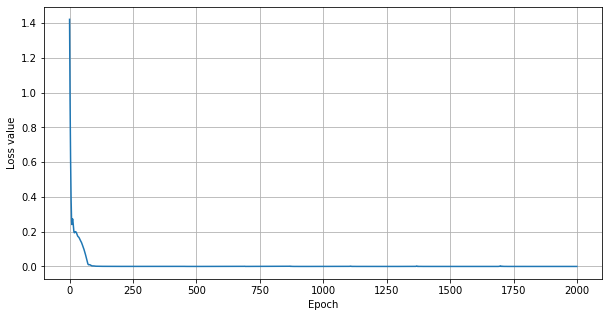

In [42]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [43]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=ResnetSolver()
    ) 

In [44]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [45]:
mse_loss(x_pred_validate, x_validate) 

tensor(1.0819, dtype=torch.float64)

In [46]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [47]:
def plot_predictions(n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validation 0


<ipython-input-47-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-47-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-47-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

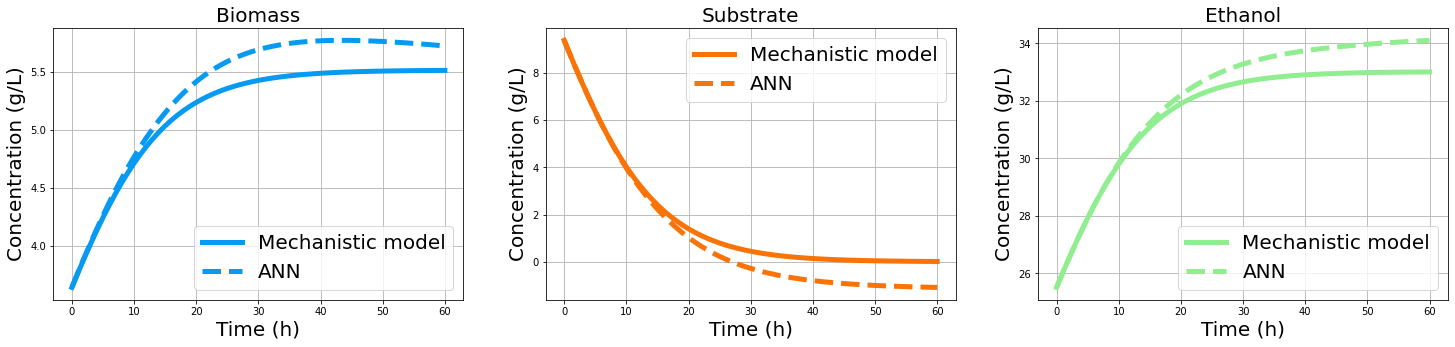

Validation 1


<ipython-input-47-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-47-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-47-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

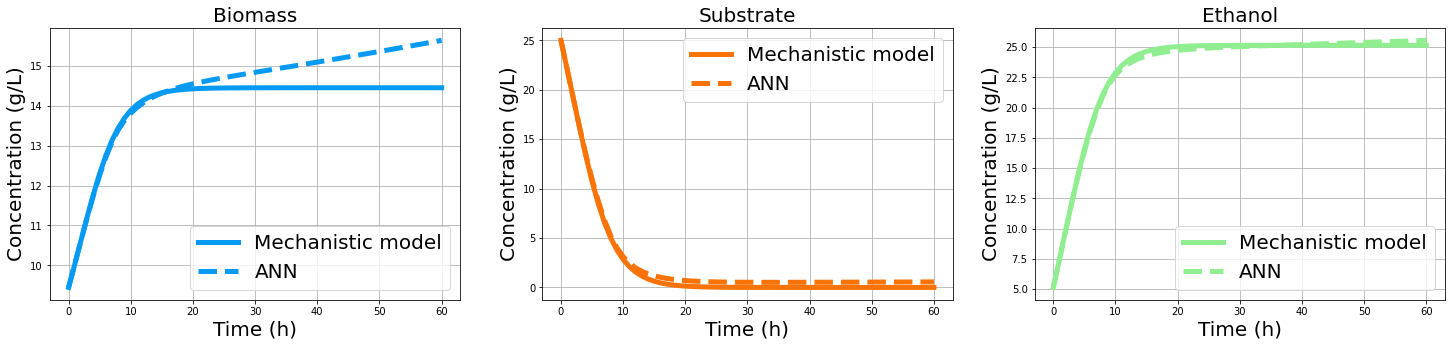

Validation 2


<ipython-input-47-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-47-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-47-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

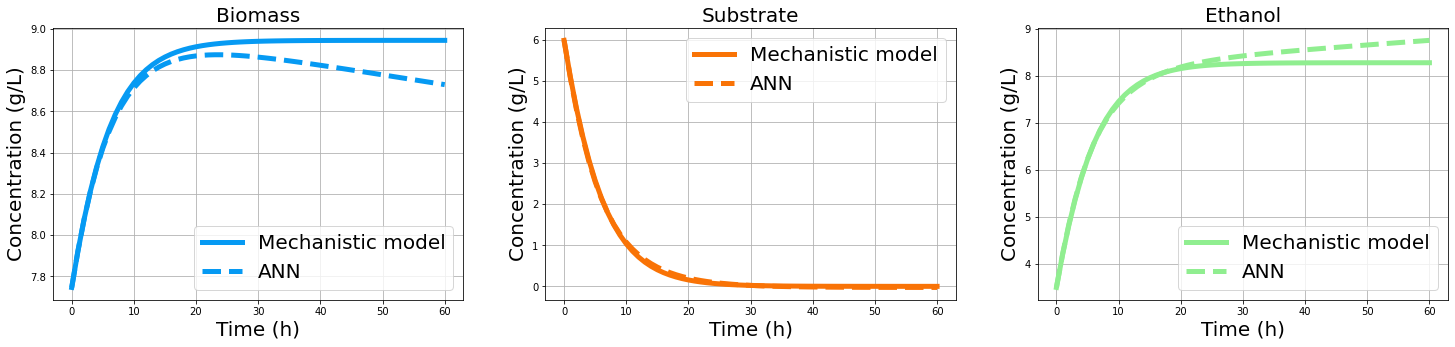

Validation 3


<ipython-input-47-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-47-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-47-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

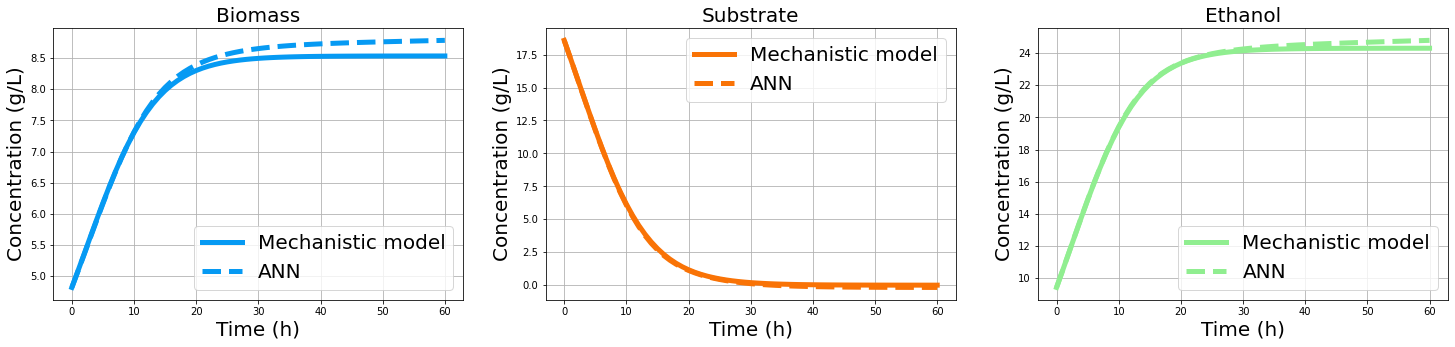

Validation 4


<ipython-input-47-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-47-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-47-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

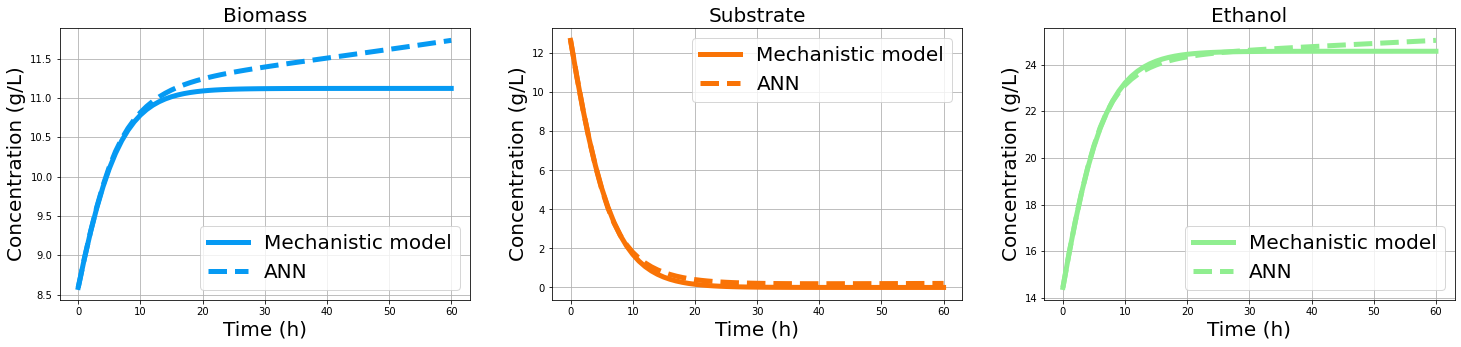

In [48]:
for i in range(5):
    plot_predictions(i)